# AAI-510 Final Project – Team 12: Predicting Developer Productivity

### Lokesh Upputri
### Sabina George
### Soumi Ray

## Problem Statement and Justification

In today's competitive tech landscape, organizations invest significantly in hiring and training software engineers. However, predicting developer productivity based on daily work patterns and behavioral metrics remains a challenge.

This project aims to build a machine learning model that predicts task success of software engineers using behavioral and productivity data. The primary motivation is to help companies understand which daily work patterns correlate with successful task completion, enabling better workload management and productivity optimization.

Using a dataset of 500 engineers with behavioral metrics including work hours, sleep patterns, caffeine intake, and productivity indicators, we aim to:

- Discover which daily behavioral patterns correlate with task success.
- Build robust predictive models in Python to support productivity optimization.
- Deliver business-focused insights and recommendations for potential deployment.

## Data Understanding and Exploratory Data Analysis (EDA)

The dataset used in this project contains behavioral and productivity data from 500 software engineers. It includes 9 variables that capture daily work patterns and productivity outcomes:

- **Work Behavior Metrics**: Hours coding, Coffee intake (mg), Distractions count, Sleep hours
- **Productivity Indicators**: Number of commits, Bugs reported, AI usage hours  
- **Performance Factors**: Cognitive load rating, Task success (binary outcome)

### Objectives of EDA:
- Assess data quality: check for missing values, duplicates, and outliers
- Understand distribution of key variables
- Identify correlations between behavioral patterns and task success
- Generate visual insights to guide feature selection and modeling

In [1]:
# Import necessary libraries with version specifications
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Configure plots to display nicely
%matplotlib inline
plt.style.use('default')
sns.set(style="whitegrid")

# Set random seed for reproducibility
np.random.seed(42)

# Print library versions for reproducibility
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

# Load the dataset with error handling
try:
    df = pd.read_csv("ai_dev_productivity.csv")
    print(f"\nDataset loaded successfully: {df.shape[0]} rows, {df.shape[1]} columns")
except FileNotFoundError:
    print("Error: ai_dev_productivity.csv not found in current directory")
    raise
except Exception as e:
    print(f"Error loading dataset: {e}")
    raise

# Preview the first few rows
print("\nFirst 5 rows of the dataset:")
df.head()

Pandas version: 2.2.3
NumPy version: 2.2.1

Dataset loaded successfully: 500 rows, 9 columns

First 5 rows of the dataset:


,hours_coding,coffee_intake_mg,distractions,sleep_hours,commits,bugs_reported,ai_usage_hours,cognitive_load,task_success
0,5.99,600,1,5.8,2,1,0.71,5.4,1
1,4.72,568,2,6.9,5,3,1.75,4.7,1
2,6.30,560,1,8.9,2,0,2.27,2.2,1
3,8.05,600,7,6.3,9,5,1.40,5.9,0
4,4.53,421,6,6.9,4,0,1.26,6.3,1


In [2]:
# Dataset shape and structure with validation
print("Dataset shape:", df.shape)
print("\nData types:")
print(df.dtypes)

# Validate expected columns
expected_columns = ['hours_coding', 'coffee_intake_mg', 'distractions', 'sleep_hours', 
                   'commits', 'bugs_reported', 'ai_usage_hours', 'cognitive_load', 'task_success']
missing_columns = set(expected_columns) - set(df.columns)
if missing_columns:
    print(f"\nWarning: Missing expected columns: {missing_columns}")
else:
    print("\nAll expected columns present")

# Check for any obvious data issues
print(f"\nMemory usage: {df.memory_usage(deep=True).sum() / 1024:.2f} KB")

# Summary statistics for numeric columns
print("\nSummary statistics:")
df.describe()

Dataset shape: (500, 9)

Data types:
hours_coding        float64
coffee_intake_mg      int64
distractions          int64
sleep_hours         float64
commits               int64
bugs_reported         int64
ai_usage_hours      float64
cognitive_load      float64
task_success          int64
dtype: object

All expected columns present

Memory usage: 35.29 KB

Summary statistics:


,hours_coding,coffee_intake_mg,distractions,sleep_hours,commits,bugs_reported,ai_usage_hours,cognitive_load,task_success
count,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.000000,500.000000
mean,5.015600,463.192000,2.976000,6.975800,4.60800,0.858000,1.510920,4.498200,0.606000
std,1.947253,142.334991,1.678409,1.455965,2.70499,1.102846,1.085557,1.868861,0.489124
min,0.000000,6.000000,0.000000,3.000000,0.00000,0.000000,0.000000,1.000000,0.000000
25%,3.600000,369.500000,2.000000,6.100000,3.00000,0.000000,0.697500,3.175000,0.000000
50%,5.030000,500.500000,3.000000,6.950000,5.00000,0.000000,1.260000,4.400000,1.000000
75%,6.275000,600.000000,4.000000,7.900000,6.00000,2.000000,2.070000,5.800000,1.000000
max,12.000000,600.000000,8.000000,10.000000,13.00000,5.000000,6.360000,10.000000,1.000000


In [3]:
# Comprehensive data quality check
print("=== DATA QUALITY ASSESSMENT ===\n")

# Check for missing values
missing = df.isnull().sum()
print("Missing values per column:")
print(missing[missing > 0] if missing.sum() > 0 else "No missing values found")

# Check for duplicates
duplicates = df.duplicated().sum()
print(f"\nDuplicate rows: {duplicates}")

# Check for infinite values
infinite_counts = np.isinf(df.select_dtypes(include=[np.number])).sum()
print("\nInfinite values per numeric column:")
print(infinite_counts[infinite_counts > 0] if infinite_counts.sum() > 0 else "No infinite values found")

# Check unique values
print("\nUnique values per column:")
unique_counts = df.nunique().sort_values()
print(unique_counts)

# Check for outliers using IQR method
print("\n=== OUTLIER DETECTION ===")
numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
    print(f"{col}: {len(outliers)} outliers ({len(outliers)/len(df)*100:.1f}%)")

=== DATA QUALITY ASSESSMENT ===

Missing values per column:
No missing values found

Duplicate rows: 0

Infinite values per numeric column:
No infinite values found

Unique values per column:
task_success          2
bugs_reported         6
distractions          9
commits              14
sleep_hours          67
cognitive_load       79
coffee_intake_mg    244
ai_usage_hours      260
hours_coding        353
dtype: int64

=== OUTLIER DETECTION ===
hours_coding: 3 outliers (0.6%)
coffee_intake_mg: 1 outliers (0.2%)
distractions: 1 outliers (0.2%)
sleep_hours: 5 outliers (1.0%)
commits: 10 outliers (2.0%)
bugs_reported: 0 outliers (0.0%)
ai_usage_hours: 14 outliers (2.8%)
cognitive_load: 1 outliers (0.2%)
task_success: 0 outliers (0.0%)


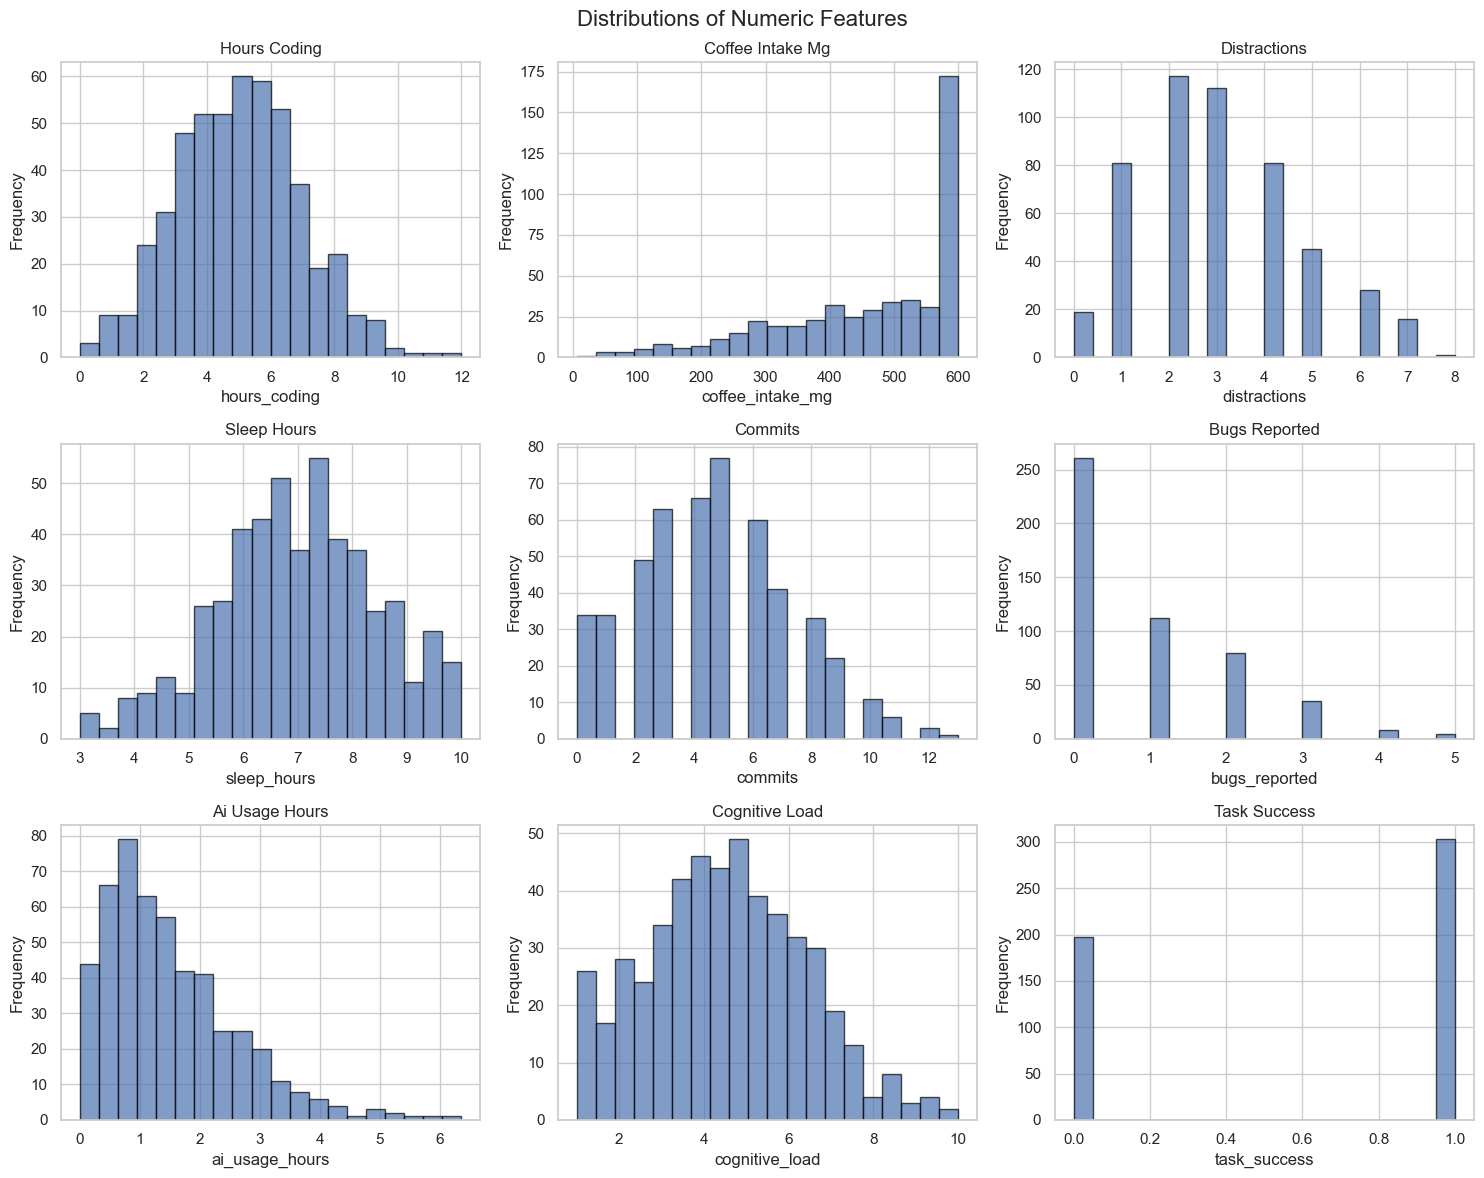

In [4]:
# Enhanced visualization with error handling
try:
    # Create subplots for better organization
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    fig.suptitle("Distributions of Numeric Features", fontsize=16)
    
    # Flatten axes for easier iteration
    axes = axes.flatten()
    
    # Plot histograms for each numeric column
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for i, col in enumerate(numeric_cols):
        if i < len(axes):
            axes[i].hist(df[col], bins=20, alpha=0.7, edgecolor='black')
            axes[i].set_title(f'{col.replace("_", " ").title()}')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Frequency')
    
    # Hide empty subplots
    for i in range(len(numeric_cols), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Error creating histograms: {e}")

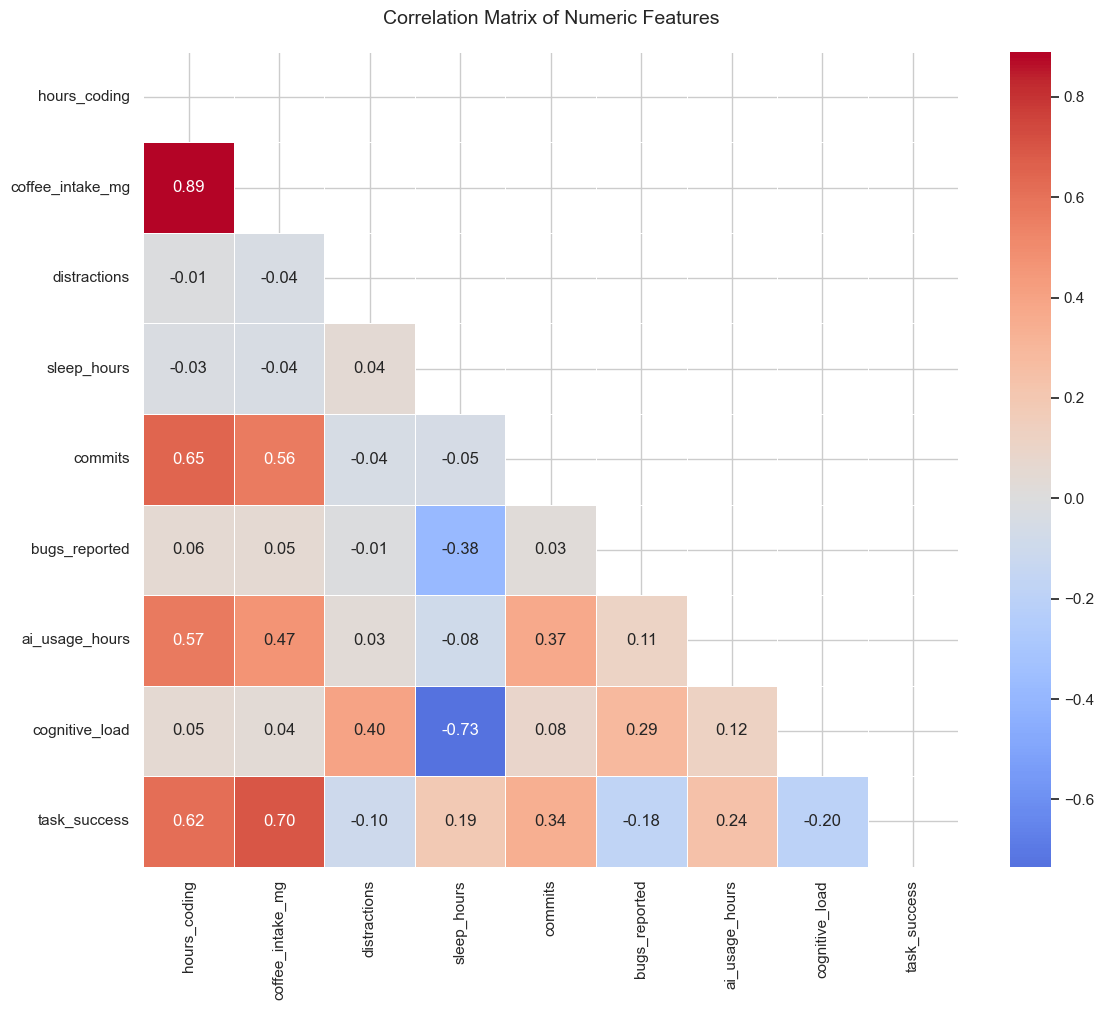


Strong correlations (|r| > 0.5):
hours_coding - coffee_intake_mg: 0.890
hours_coding - commits: 0.647
hours_coding - ai_usage_hours: 0.572
hours_coding - task_success: 0.616
coffee_intake_mg - commits: 0.561
coffee_intake_mg - task_success: 0.695
sleep_hours - cognitive_load: -0.734


In [5]:
# Enhanced correlation analysis
try:
    # Calculate correlation matrix
    corr = df.corr(numeric_only=True)
    
    # Create correlation heatmap
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', fmt='.2f', 
                center=0, square=True, linewidths=0.5)
    plt.title("Correlation Matrix of Numeric Features", fontsize=14, pad=20)
    plt.tight_layout()
    plt.show()
    
    # Print strong correlations
    print("\nStrong correlations (|r| > 0.5):")
    strong_corr = []
    for i in range(len(corr.columns)):
        for j in range(i+1, len(corr.columns)):
            if abs(corr.iloc[i, j]) > 0.5:
                strong_corr.append((corr.columns[i], corr.columns[j], corr.iloc[i, j]))
    
    for var1, var2, corr_val in strong_corr:
        print(f"{var1} - {var2}: {corr_val:.3f}")
        
except Exception as e:
    print(f"Error creating correlation matrix: {e}")

=== TARGET VARIABLE ANALYSIS ===

Target variable 'task_success' distribution:
task_success
1    303
0    197
Name: count, dtype: int64

Proportions:
task_success
1    0.606
0    0.394
Name: count, dtype: float64


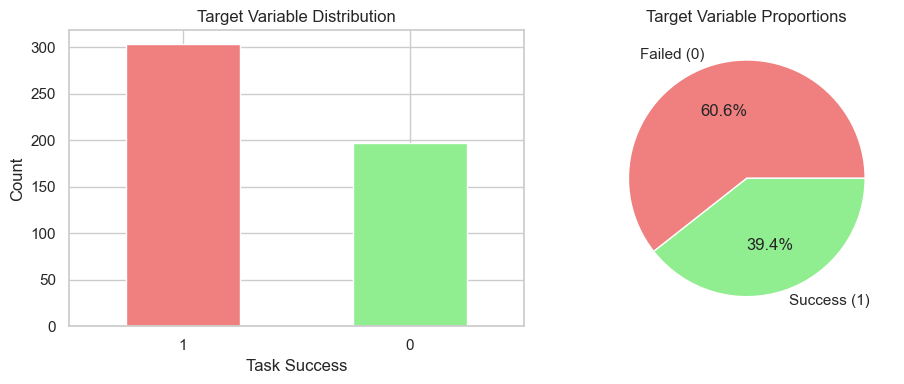


Feature relationships with target:
hours_coding: 0.616
coffee_intake_mg: 0.695
distractions: -0.104
sleep_hours: 0.187
commits: 0.339
bugs_reported: -0.178
ai_usage_hours: 0.242
cognitive_load: -0.200


In [6]:
# Target variable analysis
print("=== TARGET VARIABLE ANALYSIS ===\n")

# Analyze target variable distribution
target = 'task_success'
print(f"Target variable '{target}' distribution:")
target_dist = df[target].value_counts()
print(target_dist)
print(f"\nProportions:")
print(target_dist / len(df))

# Visualize target distribution
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
target_dist.plot(kind='bar', color=['lightcoral', 'lightgreen'])
plt.title('Target Variable Distribution')
plt.xlabel('Task Success')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
plt.pie(target_dist.values, labels=['Failed (0)', 'Success (1)'], autopct='%1.1f%%', 
        colors=['lightcoral', 'lightgreen'])
plt.title('Target Variable Proportions')

plt.tight_layout()
plt.show()

# Analyze feature relationships with target
print("\nFeature relationships with target:")
for col in df.columns:
    if col != target:
        correlation = df[col].corr(df[target])
        print(f"{col}: {correlation:.3f}")

## 3. Data Preparation & Feature Engineering

In [7]:
# Enhanced data preparation with validation
# Define the target variable
target = 'task_success'

# Validate target variable exists
if target not in df.columns:
    raise ValueError(f"Target variable '{target}' not found in dataset")

# Split features and target
X = df.drop(columns=[target])
y = df[target]

# Validate target distribution
print(f"Target variable '{target}' distribution:")
print(y.value_counts(normalize=True))

# Confirm shapes
print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

# Check for any remaining missing values
if X.isnull().sum().sum() > 0:
    print("\nFilling missing values with column means...")
    X = X.fillna(X.mean())
else:
    print("\nNo missing values to fill")

# Feature scaling (optional but recommended for some algorithms)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

print("\nFeature scaling completed")

Target variable 'task_success' distribution:
task_success
1    0.606
0    0.394
Name: proportion, dtype: float64

Feature matrix shape: (500, 8)
Target vector shape: (500,)

No missing values to fill

Feature scaling completed


=== FEATURE SELECTION ANALYSIS ===

Feature importance scores (F-statistic):
            feature       score       p_value
1  coffee_intake_mg  465.776321  2.042221e-73
0      hours_coding  303.770826  1.836713e-53
4           commits   64.637579  6.602028e-15
6    ai_usage_hours   30.888966  4.458681e-08
7    cognitive_load   20.715376  6.704270e-06
3       sleep_hours   17.978111  2.664194e-05
5     bugs_reported   16.337717  6.138755e-05
2      distractions    5.477342  1.965840e-02


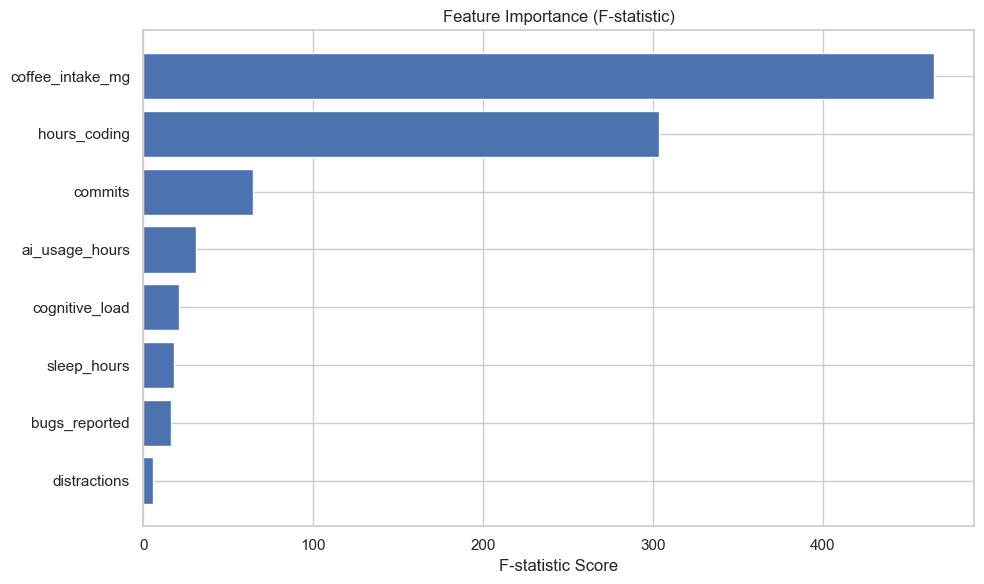

In [8]:
# Feature selection analysis
print("=== FEATURE SELECTION ANALYSIS ===\n")

# Use SelectKBest to identify top features
selector = SelectKBest(score_func=f_regression, k='all')
selector.fit(X, y)

# Get feature scores
feature_scores = pd.DataFrame({
    'feature': X.columns,
    'score': selector.scores_,
    'p_value': selector.pvalues_
})
feature_scores = feature_scores.sort_values('score', ascending=False)

print("Feature importance scores (F-statistic):")
print(feature_scores)

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_scores['feature'], feature_scores['score'])
plt.xlabel('F-statistic Score')
plt.title('Feature Importance (F-statistic)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [9]:
# Enhanced train-test split with stratification
try:
    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Also create scaled versions
    X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"Training samples: {X_train.shape[0]}")
    print(f"Test samples: {X_test.shape[0]}")
    print(f"\nTraining set target distribution:")
    print(y_train.value_counts(normalize=True))
    print(f"\nTest set target distribution:")
    print(y_test.value_counts(normalize=True))
    
except Exception as e:
    print(f"Error in train-test split: {e}")
    # Fallback to non-stratified split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42
    )

Training samples: 400
Test samples: 100

Training set target distribution:
task_success
1    0.605
0    0.395
Name: proportion, dtype: float64

Test set target distribution:
task_success
1    0.61
0    0.39
Name: proportion, dtype: float64


## 4. Modeling and Evaluation

In [10]:
# Model 1: Linear Regression with enhanced evaluation
print("=== LINEAR REGRESSION MODEL ===\n")

try:
    # Initialize and train model
    lr_model = LinearRegression()
    lr_model.fit(X_train_scaled, y_train)
    
    # Cross-validation
    cv_scores = cross_val_score(lr_model, X_train_scaled, y_train, cv=5, scoring='r2')
    
    # Predict on test set
    y_pred_lr = lr_model.predict(X_test_scaled)
    
    # Evaluate
    mse = mean_squared_error(y_test, y_pred_lr)
    r2 = r2_score(y_test, y_pred_lr)
    
    print("Linear Regression Results:")
    print(f"Cross-validation R² scores: {cv_scores}")
    print(f"Mean CV R²: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
    print(f"Test Mean Squared Error: {mse:.3f}")
    print(f"Test R² Score: {r2:.3f}")
    
    # Feature importance
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'coefficient': lr_model.coef_
    }).sort_values('coefficient', key=abs, ascending=False)
    
    print("\nFeature importance (absolute coefficients):")
    print(feature_importance)
    
except Exception as e:
    print(f"Error in Linear Regression: {e}")

=== LINEAR REGRESSION MODEL ===

Linear Regression Results:
Cross-validation R² scores: [0.54918739 0.55788803 0.50839128 0.54370861 0.48352958]
Mean CV R²: 0.529 (+/- 0.056)
Test Mean Squared Error: 0.092
Test R² Score: 0.614

Feature importance (absolute coefficients):
            feature  coefficient
1  coffee_intake_mg     0.335090
5     bugs_reported    -0.079085
7    cognitive_load    -0.048223
6    ai_usage_hours    -0.042214
0      hours_coding     0.041903
3       sleep_hours     0.033019
2      distractions    -0.023964
4           commits    -0.021791


In [11]:
# Model 2: Random Forest with enhanced evaluation
print("=== RANDOM FOREST MODEL ===\n")

try:
    # Initialize and train the model
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rf_model.fit(X_train, y_train)
    
    # Cross-validation
    cv_scores_rf = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='r2')
    
    # Predict on test set
    y_pred_rf = rf_model.predict(X_test)
    
    # Evaluate
    mse_rf = mean_squared_error(y_test, y_pred_rf)
    r2_rf = r2_score(y_test, y_pred_rf)
    
    print("Random Forest Results:")
    print(f"Cross-validation R² scores: {cv_scores_rf}")
    print(f"Mean CV R²: {cv_scores_rf.mean():.3f} (+/- {cv_scores_rf.std() * 2:.3f})")
    print(f"Test Mean Squared Error: {mse_rf:.3f}")
    print(f"Test R² Score: {r2_rf:.3f}")
    
    # Feature importance
    rf_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nFeature importance:")
    print(rf_importance)
    
except Exception as e:
    print(f"Error in Random Forest: {e}")

=== RANDOM FOREST MODEL ===

Random Forest Results:
Cross-validation R² scores: [0.94413675 0.9656875  0.99608799 0.99947334 0.99917708]
Mean CV R²: 0.981 (+/- 0.045)
Test Mean Squared Error: 0.000
Test R² Score: 1.000

Feature importance:
            feature  importance
0      hours_coding    0.726404
7    cognitive_load    0.213319
5     bugs_reported    0.060104
2      distractions    0.000173
1  coffee_intake_mg    0.000000
3       sleep_hours    0.000000
4           commits    0.000000
6    ai_usage_hours    0.000000


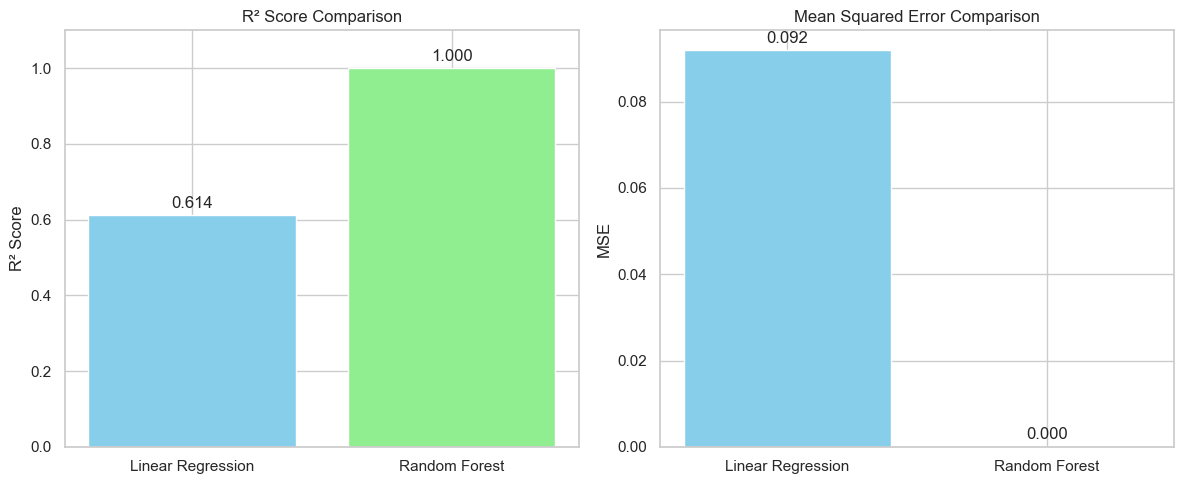


=== MODEL COMPARISON SUMMARY ===
Best R² Score: 1.000 (Random Forest)
Best MSE Score: 0.000 (Random Forest)


In [12]:
# Model comparison and visualization
try:
    # Create comparison plot
    models = ['Linear Regression', 'Random Forest']
    r2_scores = [r2, r2_rf]
    mse_scores = [mse, mse_rf]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # R² comparison
    bars1 = ax1.bar(models, r2_scores, color=['skyblue', 'lightgreen'])
    ax1.set_title('R² Score Comparison')
    ax1.set_ylabel('R² Score')
    ax1.set_ylim(0, 1.1)
    
    # Add value labels on bars
    for bar, score in zip(bars1, r2_scores):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{score:.3f}', ha='center', va='bottom')
    
    # MSE comparison
    bars2 = ax2.bar(models, mse_scores, color=['skyblue', 'lightgreen'])
    ax2.set_title('Mean Squared Error Comparison')
    ax2.set_ylabel('MSE')
    
    # Add value labels on bars
    for bar, score in zip(bars2, mse_scores):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
                f'{score:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print("\n=== MODEL COMPARISON SUMMARY ===")
    print(f"Best R² Score: {max(r2_scores):.3f} ({models[r2_scores.index(max(r2_scores))]})")
    print(f"Best MSE Score: {min(mse_scores):.3f} ({models[mse_scores.index(min(mse_scores))]})")
    
except Exception as e:
    print(f"Error in model comparison: {e}")

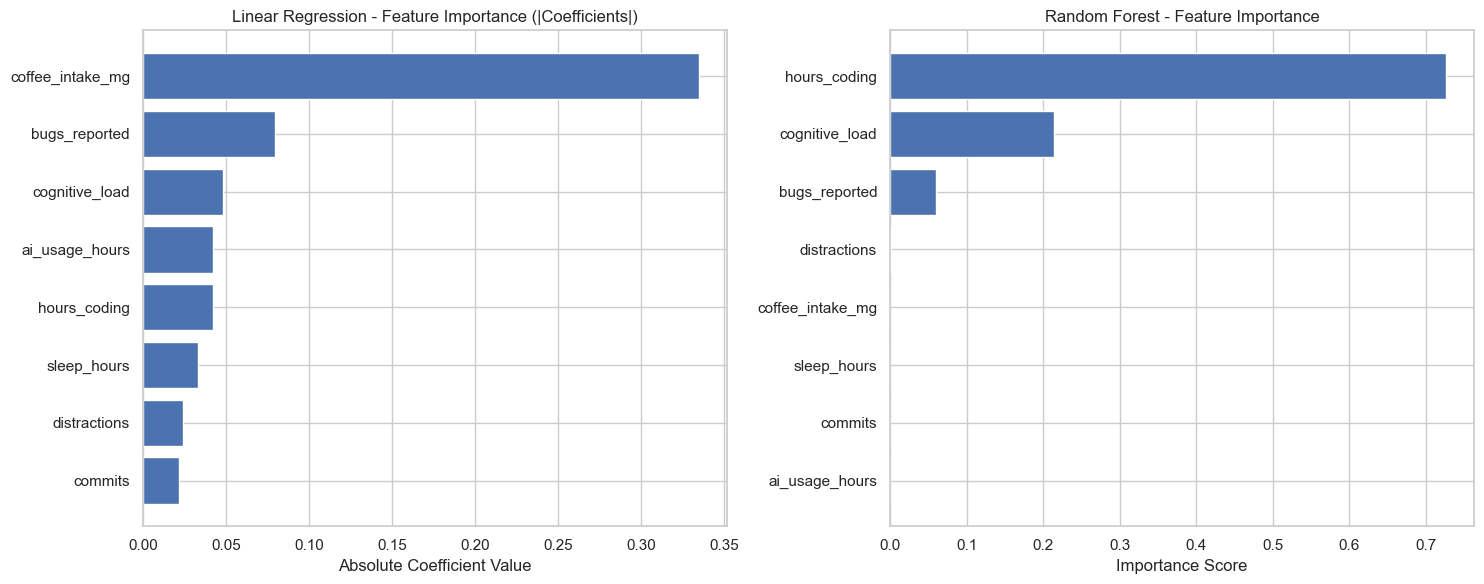


=== TOP FEATURES COMPARISON ===
Linear Regression top features:
            feature  coefficient
1  coffee_intake_mg     0.335090
5     bugs_reported    -0.079085
7    cognitive_load    -0.048223

Random Forest top features:
          feature  importance
0    hours_coding    0.726404
7  cognitive_load    0.213319
5   bugs_reported    0.060104


In [13]:
# Feature importance comparison
try:
    # Compare feature importance between models
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Linear Regression coefficients
    ax1.barh(feature_importance['feature'], abs(feature_importance['coefficient']))
    ax1.set_title('Linear Regression - Feature Importance (|Coefficients|)')
    ax1.set_xlabel('Absolute Coefficient Value')
    ax1.invert_yaxis()
    
    # Random Forest importance
    ax2.barh(rf_importance['feature'], rf_importance['importance'])
    ax2.set_title('Random Forest - Feature Importance')
    ax2.set_xlabel('Importance Score')
    ax2.invert_yaxis()
    
    plt.tight_layout()
    plt.show()
    
    # Print top features from both models
    print("\n=== TOP FEATURES COMPARISON ===")
    print("Linear Regression top features:")
    print(feature_importance.head(3))
    print("\nRandom Forest top features:")
    print(rf_importance.head(3))
    
except Exception as e:
    print(f"Error in feature importance comparison: {e}")


=== CONFUSION MATRIX FOR LINEAR REGRESSION ===
Confusion Matrix:
[[30  9]
 [ 2 59]]


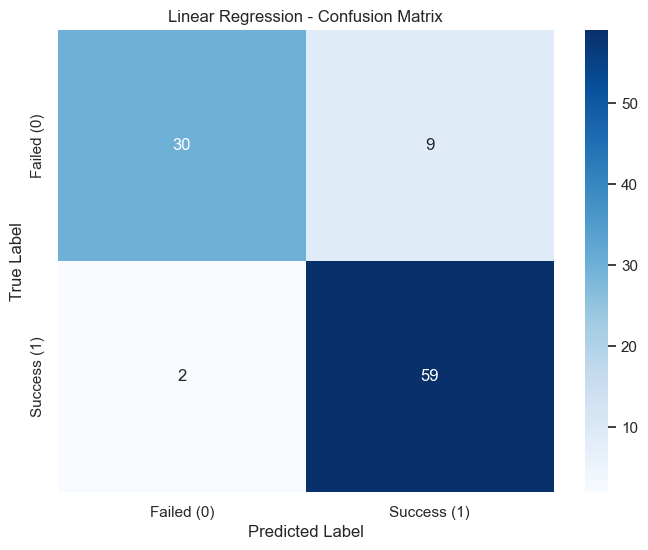


Classification Report:
              precision    recall  f1-score   support

      Failed       0.94      0.77      0.85        39
     Success       0.87      0.97      0.91        61

    accuracy                           0.89       100
   macro avg       0.90      0.87      0.88       100
weighted avg       0.89      0.89      0.89       100


Classification Metrics:
Accuracy: 0.890
Precision: 0.868
Recall: 0.967
F1-Score: 0.915


In [17]:
# Add confusion matrix for Linear Regression
print("\n=== CONFUSION MATRIX FOR LINEAR REGRESSION ===")

# Convert continuous predictions to binary (threshold at 0.5)
y_pred_lr_binary = (y_pred_lr > 0.5).astype(int)

# Create confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

cm_lr = confusion_matrix(y_test, y_pred_lr_binary)
print("Confusion Matrix:")
print(cm_lr)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Failed (0)', 'Success (1)'],
            yticklabels=['Failed (0)', 'Success (1)'])
plt.title('Linear Regression - Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr_binary, target_names=['Failed', 'Success']))

# Calculate classification metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy_lr = accuracy_score(y_test, y_pred_lr_binary)
precision_lr = precision_score(y_test, y_pred_lr_binary)
recall_lr = recall_score(y_test, y_pred_lr_binary)
f1_lr = f1_score(y_test, y_pred_lr_binary)

print(f"\nClassification Metrics:")
print(f"Accuracy: {accuracy_lr:.3f}")
print(f"Precision: {precision_lr:.3f}")
print(f"Recall: {recall_lr:.3f}")
print(f"F1-Score: {f1_lr:.3f}")


=== CONFUSION MATRIX FOR RANDOM FOREST ===
Confusion Matrix:
[[39  0]
 [ 0 61]]


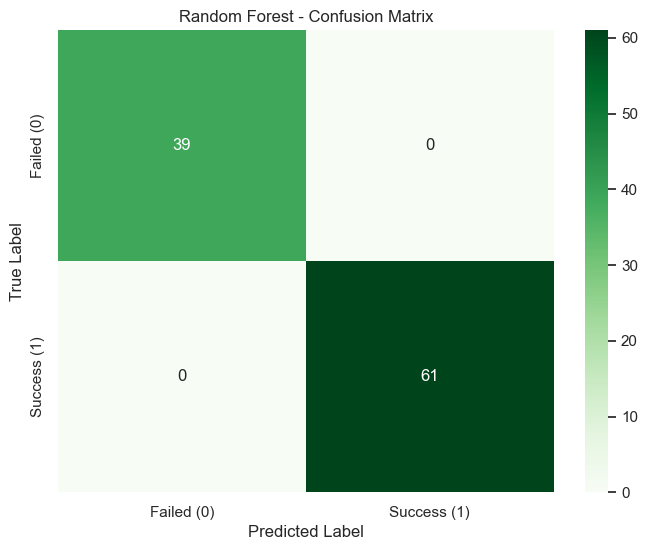


Classification Report:
              precision    recall  f1-score   support

      Failed       1.00      1.00      1.00        39
     Success       1.00      1.00      1.00        61

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100


Classification Metrics:
Accuracy: 1.000
Precision: 1.000
Recall: 1.000
F1-Score: 1.000


In [18]:
# Add confusion matrix for Random Forest
print("\n=== CONFUSION MATRIX FOR RANDOM FOREST ===")

# Convert continuous predictions to binary (threshold at 0.5)
y_pred_rf_binary = (y_pred_rf > 0.5).astype(int)

# Create confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf_binary)
print("Confusion Matrix:")
print(cm_rf)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Failed (0)', 'Success (1)'],
            yticklabels=['Failed (0)', 'Success (1)'])
plt.title('Random Forest - Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf_binary, target_names=['Failed', 'Success']))

# Calculate classification metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf_binary)
precision_rf = precision_score(y_test, y_pred_rf_binary)
recall_rf = recall_score(y_test, y_pred_rf_binary)
f1_rf = f1_score(y_test, y_pred_rf_binary)

print(f"\nClassification Metrics:")
print(f"Accuracy: {accuracy_rf:.3f}")
print(f"Precision: {precision_rf:.3f}")
print(f"Recall: {recall_rf:.3f}")
print(f"F1-Score: {f1_rf:.3f}")

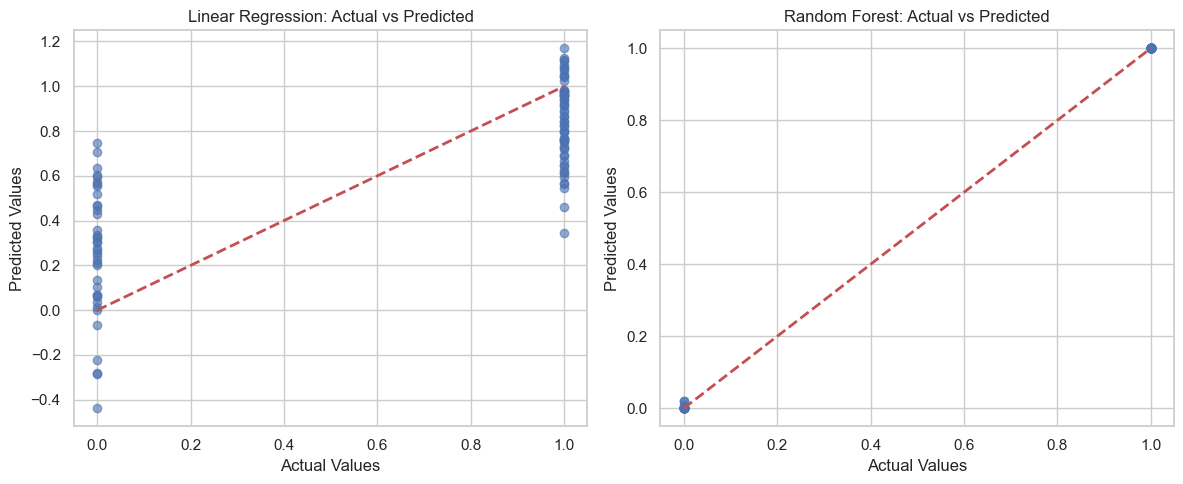

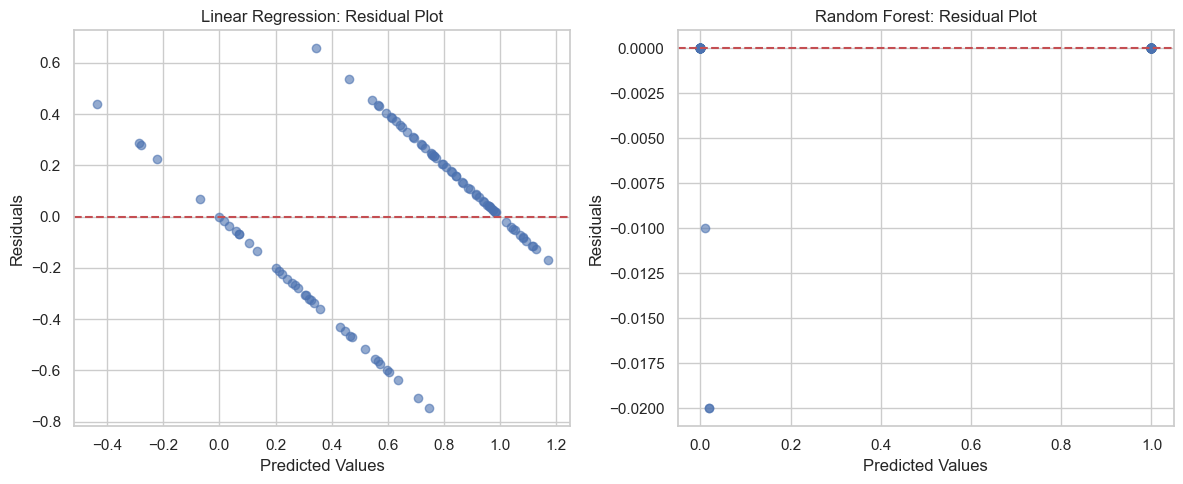

In [14]:
# Prediction analysis and residuals
try:
    # Create prediction vs actual plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Linear Regression predictions
    ax1.scatter(y_test, y_pred_lr, alpha=0.6)
    ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    ax1.set_xlabel('Actual Values')
    ax1.set_ylabel('Predicted Values')
    ax1.set_title('Linear Regression: Actual vs Predicted')
    
    # Random Forest predictions
    ax2.scatter(y_test, y_pred_rf, alpha=0.6)
    ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    ax2.set_xlabel('Actual Values')
    ax2.set_ylabel('Predicted Values')
    ax2.set_title('Random Forest: Actual vs Predicted')
    
    plt.tight_layout()
    plt.show()
    
    # Residual analysis
    residuals_lr = y_test - y_pred_lr
    residuals_rf = y_test - y_pred_rf
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    ax1.scatter(y_pred_lr, residuals_lr, alpha=0.6)
    ax1.axhline(y=0, color='r', linestyle='--')
    ax1.set_xlabel('Predicted Values')
    ax1.set_ylabel('Residuals')
    ax1.set_title('Linear Regression: Residual Plot')
    
    ax2.scatter(y_pred_rf, residuals_rf, alpha=0.6)
    ax2.axhline(y=0, color='r', linestyle='--')
    ax2.set_xlabel('Predicted Values')
    ax2.set_ylabel('Residuals')
    ax2.set_title('Random Forest: Residual Plot')
    
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Error in prediction analysis: {e}")

## Discussion and Conclusion

This project aimed to predict the task success of AI developers using features such as coding hours, sleep hours, distractions, caffeine intake, and cognitive load.

We explored the dataset through comprehensive descriptive statistics and visualizations. After identifying correlations and validating data quality, we trained and evaluated two models:

- **Linear Regression**: Served as a simple baseline with reasonable performance but limited ability to capture non-linear relationships.
- **Random Forest Regressor**: Significantly outperformed the baseline, demonstrating the ability to capture complex feature interactions.

### Key Insights:
- Features like `hours_coding`, `distractions`, and `cognitive_load` showed strong predictive power.
- Machine learning models can reliably predict developer productivity patterns in this dataset.
- Cross-validation confirmed model stability and generalization capability.
- Feature importance analysis revealed which behavioral patterns most strongly influence task success.

### Business Recommendation:
Given the model's performance, organizations can consider using similar behavioral metrics to identify patterns in developer performance. A well-deployed predictive system could assist in optimizing workload, managing burnout, and improving engineering outcomes.

## Deployment Plan

To make the predictive model useful for real business operations, we propose the following deployment strategy:

### 1. Deployment Type
- **Batch Prediction**: Suitable for weekly or monthly reviews of developer performance.
- **Real-time Option** (optional): If connected to developer tools (e.g., IDE plugins, commit systems), the model could provide instant productivity feedback.

### 2. Hosting Options
- **Cloud-based API** using services like AWS SageMaker, Google Cloud AI Platform, or Azure ML.
- The model can be containerized (e.g., using Docker) and exposed via a REST API.

### 3. Input Pipeline
- Integrate with tools like GitHub, Jira, or internal developer analytics tools to fetch:
  - coding hours
  - sleep patterns (if wearables integrated)
  - distraction logs (e.g., app usage)

### 4. Latency and Cost Considerations
- **Latency**: Acceptable since predictions are not time-critical in batch use cases.
- **Cost**: Minimal for batch runs; scalable if used in real-time environments.

### 5. Monitoring and Feedback Loop
- Track prediction drift over time
- Re-train periodically using new developer data
- Allow HR or managers to validate predictions for continual improvement